<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Final Project</div>
<div style="text-align: right">Group 1:</div>
<div style="text-align: right">Anish Gupta,  Darasy Reth, Sajida Mohammad, Taneja Shreya</div>
<div style="text-align: right">{gupta.anis, reth.d, mohammad.sa, taneja.sh} @husky.neu.edu</div>

# Skin Cancer Detection: HAM10000
# Convolutional Neural Network

$\begin{pmatrix}
Own\ Code\ Lines & 60 \\
External\ Code\ Lines & 65 \\
Existing\ Accuracy & 77\%\ classifying\ each\ label\\
Our\ Accuracy & 75.5\% \\
Time\ to\ run & 10\ min
\end{pmatrix}$

### Import necessary packages

Tutorioal from the dataset author regarding importing and processing data.

Source: https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Import the dataset

#### The dataset can be found on the shared folder that Ravi made since this whole dataset is 2.6GB.

In [2]:
data_dir = 'Project_gc_1' # Base folder directory

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_dir ,'*' ,'*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# Reading Metadata
skin_df = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Prepare the data

In [4]:
# Creating New Columns for better readability
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

'''
0: No cancerous
1: Cancerous

Melanocytic nevi (cancerous)
Melanoma (cancerous)
Dermatofibroma (non-cancerous)
Benign keratosis-like lesions (non-cancerous)
Basal cell carcinoma (cancerous)
Vascular lesio150ns (cancerous)
Actinic keratoses and intraepithelial carcinoma / Bowen's disease (cancerous)
'''

skin_df['cancerous_status'] = [1 if (skin_df['cell_type'][i] == "Melanocytic nevi" or
                                   skin_df['cell_type'][i] == "Melanoma" or
                                   skin_df['cell_type'][i] == "Basal cell carcinoma" or
                                   skin_df['cell_type'][i] == "Vascular lesions" or
                                   skin_df['cell_type'][i] == "ctinic keratoses and intraepithelial carcinoma / Bowen's disease")
                               else 0 
                               for i in range(0, len(skin_df['cell_type']))
                              ]
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,cancerous_status
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Project_gc_1/HAM10000_images_part_1/ISIC_00274...,Benign keratosis-like lesions,2,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Project_gc_1/HAM10000_images_part_1/ISIC_00250...,Benign keratosis-like lesions,2,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Project_gc_1/HAM10000_images_part_1/ISIC_00267...,Benign keratosis-like lesions,2,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Project_gc_1/HAM10000_images_part_1/ISIC_00256...,Benign keratosis-like lesions,2,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Project_gc_1/HAM10000_images_part_2/ISIC_00316...,Benign keratosis-like lesions,2,0


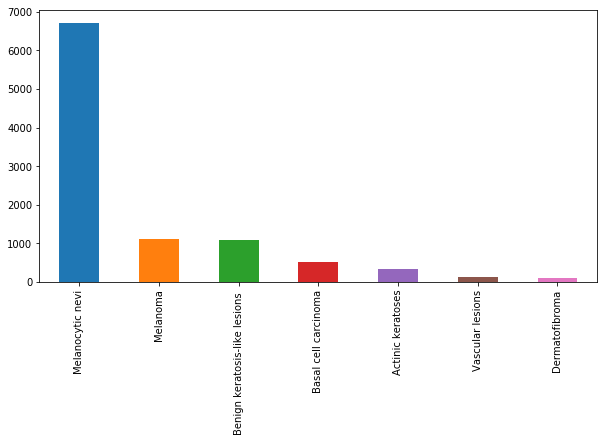

In [5]:
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cell_type'].value_counts().plot(kind='bar', ax=axis)

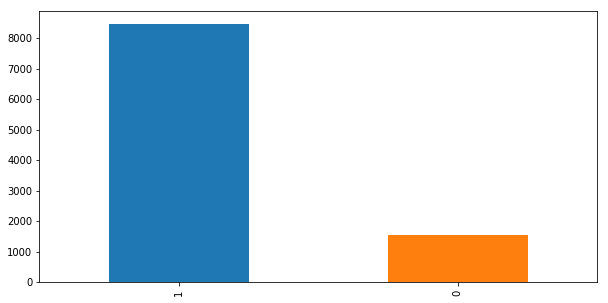

In [6]:
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cancerous_status'].value_counts().plot(kind='bar', ax=axis)

We can see from the graph above that "Melanocytic nevi" dominate other classes significantly which cause a problem of imbalanced data where Melanocytic nevi will affect the prediction of other skin cancer classes.

Reducing "Melanocytic nevi" data method

Source: https://www.kaggle.com/yuningalexliu/dermatology-image-classification

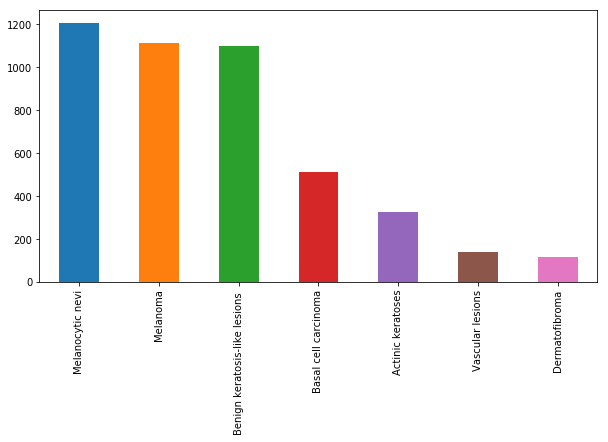

In [7]:
skin_df = skin_df.drop(skin_df[skin_df.cell_type_idx == 4].iloc[:5500].index)
# The new distribution of different cell types after reducing cell index '4'
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cell_type'].value_counts().plot(kind='bar', ax=axis)

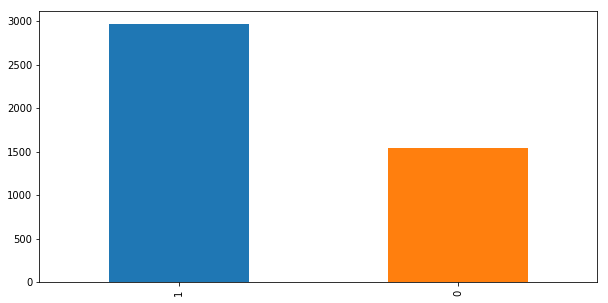

In [8]:
axis = plt.subplots(1, 1, figsize= (10, 5))[1]
skin_df['cancerous_status'].value_counts().plot(kind='bar', ax=axis)

While these data indicates an imbalanced dataset, this is still better since data of "Melanocytic nevi" now does not dominate other skin cancer data too much as shown previously.

In [9]:
#resizing images
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [10]:
target = skin_df['cancerous_status']

In [11]:
features = skin_df.drop(columns=['cancerous_status'],axis=1)

### Split the dataset into training data (80%) and testing data (20%)

We split the data into 80% for training and 20% for testing using the random state generator of 42.

In [12]:
skin_train_o, skin_test_o, skin_label_train_o, skin_label_test_o = train_test_split(features, target, test_size = 0.2, random_state=42)

### Normalization

In [13]:
# Use only an image as a feature
x_train = np.asarray(skin_train_o['image'].tolist())
x_test = np.asarray(skin_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [14]:
# Hot encoding
y_train = to_categorical(skin_label_train_o, num_classes = 2)
y_test = to_categorical(skin_label_test_o, num_classes = 2)

In [15]:
x_train.shape

(3612, 75, 100, 3)

### Build Convolutional Neural Network Classifer 

In [16]:
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(75, 100, 3)))
# Convolutional Layer 1
cnn.add(Conv2D(64, (3, 3), activation='relu')) # Apply RELU
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))

# Convolutional Layer 2
cnn.add(Conv2D(64, (3, 3), activation='relu')) # Apply RELU
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Dropout(0.5))

cnn.add(Flatten()) # Flatten
cnn.add(Dense(128, activation='relu')) # Fully Connected Layer
cnn.add(Dropout(0.5))

# Applying softmax
cnn.add(Dense(2, activation='softmax')) # Apply Softmax

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
# Compile the model using categorical_crossentropy and adam optimizer
cnn.compile(loss=keras.losses.categorical_crossentropy, metrics=['accuracy'], optimizer='adam')

In [18]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint
batch_size = 64
epochs = 12

history = cnn.fit(x_train, y_train,
                  batch_size=batch_size,
                  verbose = 1,
                  epochs=epochs,
                  validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 3612 samples, validate on 903 samples
Epoch 1/12
3612/3612 [==============================] - 46s 13ms/step - loss: 0.7588 - acc: 0.6459 - val_loss: 0.6348 - val_acc: 0.6523
Epoch 2/12
3612/3612 [==============================] - 39s 11ms/step - loss: 0.5826 - acc: 0.6728 - val_loss: 0.6257 - val_acc: 0.6777
Epoch 3/12
3612/3612 [==============================] - 39s 11ms/step - loss: 0.5890 - acc: 0.6880 - val_loss: 0.5987 - val_acc: 0.6788
Epoch 4/12
3612/3612 [==============================] - 39s 11ms/step - loss: 0.5730 - acc: 0.6988 - val_loss: 0.5830 - val_acc: 0.6955
Epoch 5/12
3612/3612 [==============================] - 40s 11ms/step - loss: 0.5690 - acc: 0.7040 - val_loss: 0.5959 - val_acc: 0.7099
Epoch 6/12
3612/3612 [==============================] - 39s 11ms/step - loss: 0.5408 - acc: 0.7176 - val_loss: 0.6045 - val_acc: 0.6899
Epoch 7/12
3612/3612 [==============================] - 39s 11ms/step - loss: 0.5395 - ac

Now let's apply the model on the test data.

In [19]:
loss, acc = cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.5098546589595799
Test accuracy: 0.7552602438303587


The model works quite well for the testing data with the accuracy of 75.5% and loss with the value of 0.5.

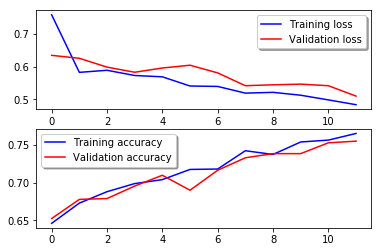

In [20]:
# Loss and accuracy curves for both training and testing data
axis = plt.subplots(2,1)[1]
axis[0].plot(history.history['loss'], color='b', label="Training loss")
axis[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =axis[0])
legend = axis[0].legend(loc='best', shadow=True)

axis[1].plot(history.history['acc'], color='b', label="Training accuracy")
axis[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = axis[1].legend(loc='best', shadow=True)

As the graph shown, the perform of the model works quite in just 12 epochs where both training and testing accuracies improve over time, while both training and testing loss reduce over these 12 steps. At the end of the training, we achieve 75.5% for testing dataset and 76.5% for training dataset where both have loss value less than 0.6 at the end.